# EnUygun Test Dataset Customer Segmentation #

#### Libraries

In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

#### Database Connection

In [2]:
cnxn_str = ("Driver={SQL Server Native Client 11.0};"
            "Server=***CENSORED_HERE***;"
            "Database=enuygun2;"
            "Trusted_Connection=yes;")
cnxn = pyodbc.connect(cnxn_str)
cursor = cnxn.cursor()

#### Prepared Sql Query for RFM Analysis

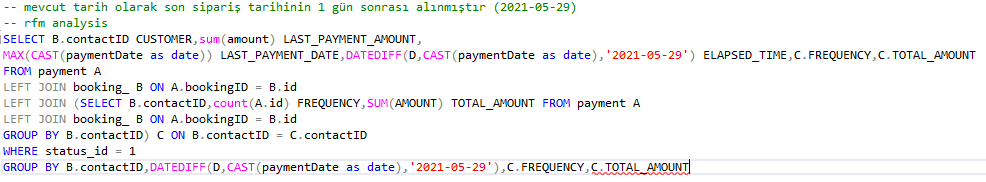

#### Reading Sql Query as dataframe

In [3]:
dataset = pd.read_sql("SELECT B.contactID CUSTOMER,sum(amount) LAST_PAYMENT_AMOUNT, MAX(CAST(paymentDate as date)) LAST_PAYMENT_DATE,DATEDIFF(D,CAST(paymentDate as date),'2021-05-29') ELAPSED_TIME,C.FREQUENCY,C.TOTAL_AMOUNT FROM payment A LEFT JOIN booking_ B ON A.bookingID = B.id LEFT JOIN (SELECT B.contactID,count(A.id) FREQUENCY,SUM(AMOUNT) TOTAL_AMOUNT FROM payment A LEFT JOIN booking_ B ON A.bookingID = B.id GROUP BY B.contactID) C ON B.contactID = C.contactID WHERE status_id = 1 GROUP BY B.contactID,DATEDIFF(D,CAST(paymentDate as date),'2021-05-29'),C.FREQUENCY,C.TOTAL_AMOUNT",cnxn)

#### Browsing the dataset

- __112324 Customer__
1. CustomerID
- __6 Columns__  
1. Customer, 
2. Last Payment Amount 
3. Last Payment Date
4. Elapsed Time(From last payment date)
5. Frequency(Number of payment)
6. Total Amount

In [4]:
dataset.head()

,CUSTOMER,LAST_PAYMENT_AMOUNT,LAST_PAYMENT_DATE,ELAPSED_TIME,FREQUENCY,TOTAL_AMOUNT
0,944773,18,2020-01-15,500,1,18
1,1255828,40,2020-02-19,465,3,120
2,1246564,50,2020-02-17,467,1,50
3,1336015,15,2020-03-07,448,1,15
4,1424707,85,2020-03-19,436,1,85


In [5]:
dataset.shape

(112324, 6)

#### Dataset statistics

In [6]:
dataset[['ELAPSED_TIME','FREQUENCY']].describe()

,ELAPSED_TIME,FREQUENCY
count,112324.000000,112324.000000
mean,281.012873,2.781605
std,165.286079,3.566590
min,1.000000,1.000000
25%,124.000000,1.000000
50%,294.000000,2.000000
75%,451.000000,3.000000
max,533.000000,49.000000


#### Plotting Customer Percentiles by Recency(based on Elapsed Time column)

- __%44__ of customers have purchased between __120-365__ days
- __%33__ of customers have purchased between __365-900__ days
- __%12__ of customers have purchased between __60-120__ days
- __%4__ of customers have purchased between __30-45__ days
- __%2__ of customers have purchased between __15-30__ days
- __%3__ of customers have purchased between __45-60__ days
- __%3__ of customers have purchased between __1-15__ days

Text(0.5, 1.0, 'Customer Percentiles by Recency')

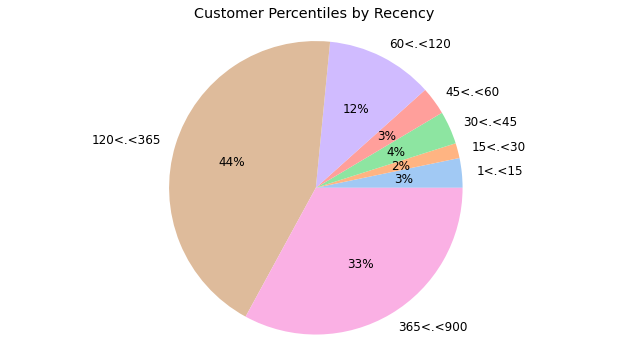

In [7]:
time_range = [1, 15, 30, 45, 60, 120, 365, 900]
count_price = []
for i, price in enumerate(time_range):
    if i == 0: continue
    val = dataset[(dataset['ELAPSED_TIME'] < price) &
                       (dataset['ELAPSED_TIME'] > time_range[i-1])]['ELAPSED_TIME'].count()
    count_price.append(val)


#plotting
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots(figsize=(11, 6))
colors = sns.color_palette('pastel')[0:7]
labels = [ '{}<.<{}'.format(time_range[i-1], s) for i,s in enumerate(time_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 15 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
plt.title('Customer Percentiles by Recency')

#### Plotting Customer Percentiles by Monetary Value(based on Total Amount column)

- __%38__ of customers have spent between __0-100__ 
- __%18__ of customers have spent between __100-200__ 
- __%15__ of customers have spent between __200-400__ 
- __%13__ of customers have spent between __400-700__ 
- __%7__ of customers have spent between __1000-2000__ 
- __%6__ of customers have spent between __700-1000__ 
- __%3__ of customers have spent between __2000-5000__ 

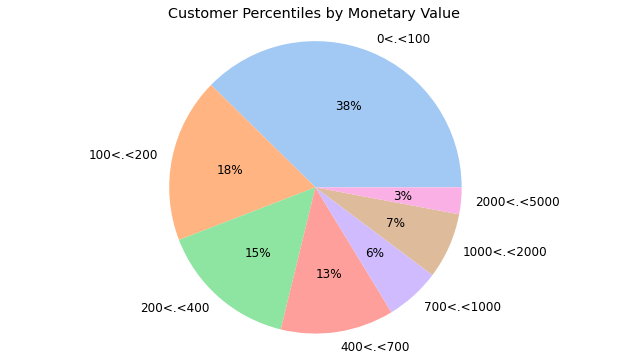

In [8]:
amount_range = [0, 100, 200, 400, 700, 1000, 2000, 5000]
count_price = []
for i, price in enumerate(amount_range):
    if i == 0: continue
    val = dataset[(dataset['TOTAL_AMOUNT'] < price) &
                       (dataset['TOTAL_AMOUNT'] > amount_range[i-1])]['TOTAL_AMOUNT'].count()
    count_price.append(val)

#plotting
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots(figsize=(11, 6))
colors = sns.color_palette('pastel')[0:7]
labels = [ '{}<.<{}'.format(amount_range[i-1], s) for i,s in enumerate(amount_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
plt.title('Customer Percentiles by Monetary Value')
plt.show()

#### Feature correlations between columns

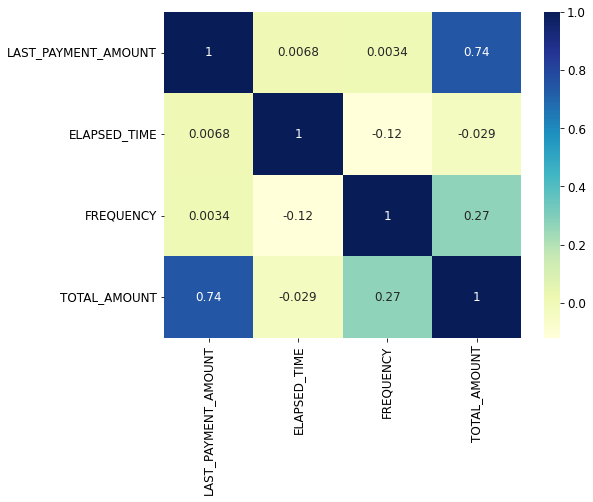

,LAST_PAYMENT_AMOUNT,ELAPSED_TIME,FREQUENCY,TOTAL_AMOUNT
LAST_PAYMENT_AMOUNT,1.000000,0.006793,0.003372,0.743545
ELAPSED_TIME,0.006793,1.000000,-0.120696,-0.029283
FREQUENCY,0.003372,-0.120696,1.000000,0.269913
TOTAL_AMOUNT,0.743545,-0.029283,0.269913,1.000000


In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(dataset[['LAST_PAYMENT_AMOUNT','ELAPSED_TIME','FREQUENCY','TOTAL_AMOUNT']].corr(),cmap="YlGnBu",annot=True)
plt.show()

dataset[['LAST_PAYMENT_AMOUNT','ELAPSED_TIME','FREQUENCY','TOTAL_AMOUNT']].corr()

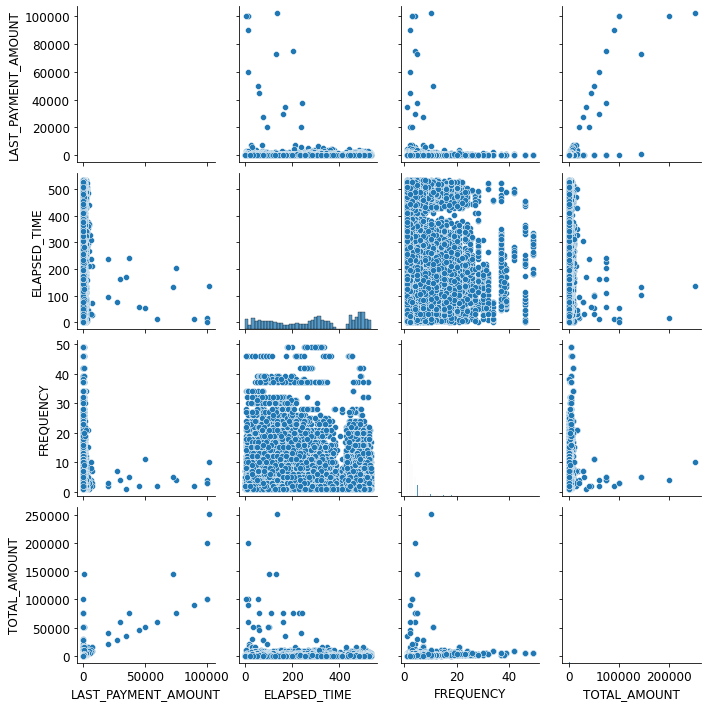

In [10]:
sns.pairplot(dataset[['LAST_PAYMENT_AMOUNT','ELAPSED_TIME','FREQUENCY','TOTAL_AMOUNT']], diag_kind="hist")

#### Manipulating dataframe for RFM analysis(to customer segmentation)

- Recency - Elapsed Time column
- Frequency - Frequency column
- Monetary - Total amount column

In [11]:
df1 = dataset[['CUSTOMER','ELAPSED_TIME','FREQUENCY','TOTAL_AMOUNT']].copy()
df1.columns = ['CustomerID','Recency', 'Frequency', 'Monetary']
df1.head()

,CustomerID,Recency,Frequency,Monetary
0,944773,500,1,18
1,1255828,465,3,120
2,1246564,467,1,50
3,1336015,448,1,15
4,1424707,436,1,85


#### Split columns into percentiles
%25 - %50 - %75

In [12]:
quantiles = df1.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [13]:
quantiles

{'CustomerID': {0.25: 1157746.75, 0.5: 1691368.0, 0.75: 2184643.0},
 'Recency': {0.25: 124.0, 0.5: 294.0, 0.75: 451.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0},
 'Monetary': {0.25: 70.0, 0.5: 150.0, 0.75: 460.0}}

#### Functions for splitting

###### Receny Scoring
- %25 -> returns 1
- %50 -> returns 2
- %75 -> returns 3
- else 4

###### Frequency and Monetary scoring
- %25 -> returns 4
- %50 -> returns 3
- %75 -> returns 2
- else 1

In [14]:
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [15]:
df1['R'] = df1['Recency'].apply(RScoring, args=('Recency',quantiles,))
df1['F'] = df1['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
df1['M'] = df1['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
df1.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,944773,500,1,18,4,4,4
1,1255828,465,3,120,4,2,3
2,1246564,467,1,50,4,4,4
3,1336015,448,1,15,3,4,4
4,1424707,436,1,85,3,4,3


#### Concatenating scores as string to new column & Sum scores as new column

In [16]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
df1['RFMGroup'] = df1.R.map(str) + df1.F.map(str) + df1.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
df1['RFMScore'] = df1[['R', 'F', 'M']].sum(axis = 1)
df1.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
0,944773,500,1,18,4,4,4,444,12
1,1255828,465,3,120,4,2,3,423,9
2,1246564,467,1,50,4,4,4,444,12
3,1336015,448,1,15,3,4,4,344,11
4,1424707,436,1,85,3,4,3,343,10


#### Assign Bronze to Platinum level to each customer

In [17]:
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(df1.RFMScore, q = 4, labels = Loyalty_Level)
df1['RFM_Loyalty_Level'] = Score_cuts.values
df1.reset_index().head()

,index,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,0,944773,500,1,18,4,4,4,444,12,Bronze
1,1,1255828,465,3,120,4,2,3,423,9,Silver
2,2,1246564,467,1,50,4,4,4,444,12,Bronze
3,3,1336015,448,1,15,3,4,4,344,11,Bronze
4,4,1424707,436,1,85,3,4,3,343,10,Silver


#### Validate the data

1. Platinum group must be 
- __Recency -> less__
- __Frequency -> many__
- __Monetary -> many__

In [18]:
df1[df1['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head()

,index,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,88943,2604976,15,4,200000,1,1,1,111,3,Platinum
1,112034,2263288,102,5,145725,1,1,1,111,3,Platinum
2,10027,2128108,59,4,75205,1,1,1,111,3,Platinum
3,75408,2128108,109,4,75205,1,1,1,111,3,Platinum
4,43229,2360110,99,11,51550,1,1,1,111,3,Platinum


#### Plotting data distribution

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

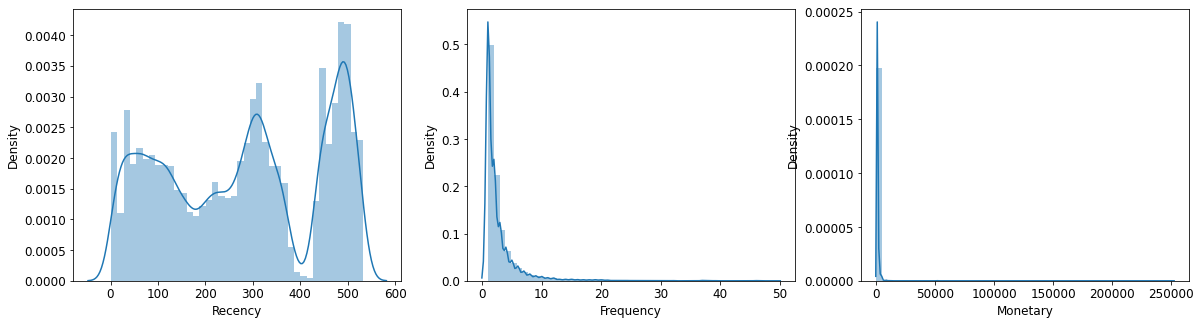

In [19]:
#Plot data distribution
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.distplot(df1['Recency'])

plt.subplot(1,3,2)
sns.distplot(df1['Frequency'])

plt.subplot(1,3,3)
sns.distplot(df1['Monetary'])

#### Log transformation for normalization

In [20]:
df1_log = df1[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis=1).round(3)
df1_log.head()

,Recency,Frequency,Monetary
0,6.215,0.000,2.890
1,6.142,1.099,4.787
2,6.146,0.000,3.912
3,6.105,0.000,2.708
4,6.078,0.000,4.443


#### Plotting the data distribution after log transformation

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

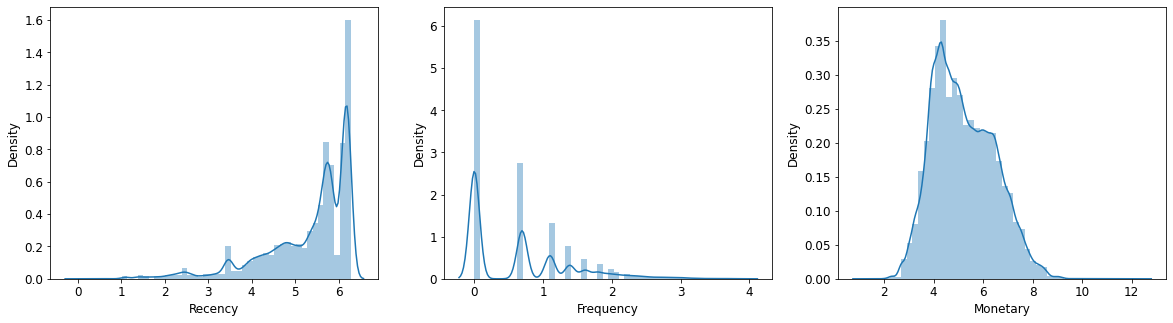

In [21]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.distplot(df1_log['Recency'])

plt.subplot(1,3,2)
sns.distplot(df1_log['Frequency'])

plt.subplot(1,3,3)
sns.distplot(df1_log['Monetary'])

In [22]:
df1_log.describe()

,Recency,Frequency,Monetary
count,112324.000000,112324.000000,112324.000000
mean,5.316077,0.645794,5.208620
std,0.999919,0.764800,1.234796
min,0.000000,0.000000,1.099000
25%,4.820000,0.000000,4.248000
50%,5.684000,0.693000,5.011000
75%,6.111000,1.099000,6.131000
max,6.279000,3.892000,12.437000


#### Data standartization for K-Means clustering algorithm

In [23]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1_log)

In [24]:
df1_scaled = pd.DataFrame(df1_scaled, index=df1.index, columns= df1_log.columns)
df1_scaled.head()

,Recency,Frequency,Monetary
0,0.899000,-0.844400,-1.877744
1,0.825993,0.592584,-0.341451
2,0.829994,-0.844400,-1.050073
3,0.788990,-0.844400,-2.025138
4,0.761988,-0.844400,-0.620041


### K-Means clustering for customer segmentation

#### Choosing the optimal K value with elbow method

According to the plot graphing, K=4 looks optimal

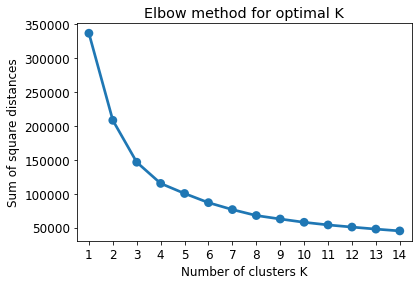

In [25]:
#wcss stands for within cluster sum of squares
wcss={}

for k in range(1,15):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000 , random_state=20)
    km = km.fit(df1_scaled)
    wcss[k] = km.inertia_
    
#Plot graph for the wcss values and the number of clusters
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.xlabel('Number of clusters K')
plt.ylabel('Sum of square distances')
plt.title('Elbow method for optimal K')
plt.show()

#### Building K-Means clustering model with K=4 value

In [26]:
kmean_model = KMeans(n_clusters=4, init='k-means++', max_iter=1000, random_state=20)
kmean_model.fit(df1_scaled)

KMeans(max_iter=1000, n_clusters=4, random_state=20)

#### Find the clusters into Cluster column

In [27]:
df1['Cluster'] = kmean_model.labels_

In [28]:
df1.Cluster.value_counts()

0    40876
2    35164
1    18794
3    17490
Name: Cluster, dtype: int64

#### Checking the dataset

In [29]:
df1.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
0,944773,500,1,18,4,4,4,444,12,Bronze,0
1,1255828,465,3,120,4,2,3,423,9,Silver,2
2,1246564,467,1,50,4,4,4,444,12,Bronze,0
3,1336015,448,1,15,3,4,4,344,11,Bronze,0
4,1424707,436,1,85,3,4,3,343,10,Silver,0


### No:0 Cluster Features 

- __Recency__ means __268__
- __Frequency__ means __3__
- __Monetary__ means __542__

In [30]:
df1[df1['Cluster']==0].describe()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMScore,Cluster
count,4.087600e+04,40876.000000,40876.000000,40876.000000,40876.000000,40876.000000,40876.000000,40876.000000,40876.0
mean,1.547236e+06,341.540831,1.138541,69.255064,2.879905,3.861459,3.570653,10.312017,0.0
std,5.429301e+05,135.722447,0.365163,36.457196,0.966161,0.365163,0.563062,1.173432,0.0
min,2.710000e+02,63.000000,1.000000,3.000000,1.000000,1.000000,2.000000,7.000000,0.0
25%,1.105518e+06,238.000000,1.000000,45.000000,2.000000,4.000000,3.000000,10.000000,0.0
50%,1.587426e+06,333.000000,1.000000,60.000000,3.000000,4.000000,4.000000,10.000000,0.0
75%,2.022254e+06,478.000000,1.000000,90.000000,4.000000,4.000000,4.000000,11.000000,0.0
max,2.462281e+06,533.000000,4.000000,200.000000,4.000000,4.000000,4.000000,12.000000,0.0


### No:1 Cluster Features 

- __Recency__ means __352__
- __Frequency__ means __2__
- __Monetary__ means __432__

In [31]:
df1[df1['Cluster']==1].describe()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMScore,Cluster
count,1.879400e+04,18794.00000,18794.000000,18794.000000,18794.000000,18794.000000,18794.000000,18794.000000,18794.0
mean,1.592653e+06,234.56103,8.298340,1424.308716,2.177663,1.067256,1.217676,4.462594,1.0
std,6.207719e+05,147.14179,5.899305,3810.145043,1.017690,0.262301,0.423369,1.065417,0.0
min,2.338000e+03,3.00000,1.000000,105.000000,1.000000,1.000000,1.000000,3.000000,1.0
25%,1.100209e+06,107.00000,5.000000,510.000000,1.000000,1.000000,1.000000,4.000000,1.0
50%,1.668192e+06,213.00000,6.000000,915.000000,2.000000,1.000000,1.000000,4.000000,1.0
75%,2.113090e+06,331.00000,10.000000,1633.000000,3.000000,1.000000,1.000000,5.000000,1.0
max,2.629912e+06,533.00000,49.000000,252000.000000,4.000000,4.000000,3.000000,8.000000,1.0


### No:2 Cluster Features 

- __Recency__ means __341__
- __Frequency__ means __1.14__
- __Monetary__ means __70__

In [32]:
df1[df1['Cluster']==2].describe()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMScore,Cluster
count,3.516400e+04,35164.000000,35164.000000,35164.000000,35164.000000,35164.000000,35164.000000,35164.000000,35164.0
mean,1.460782e+06,352.448498,2.188033,428.031595,2.968035,2.830622,1.846974,7.645632,2.0
std,5.313038e+05,125.925300,0.996578,365.630611,0.892257,0.950517,0.694283,1.369105,0.0
min,1.570000e+02,66.000000,1.000000,60.000000,1.000000,1.000000,1.000000,4.000000,2.0
25%,1.053092e+06,266.000000,1.000000,185.000000,2.000000,2.000000,1.000000,7.000000,2.0
50%,1.501842e+06,344.000000,2.000000,304.000000,3.000000,3.000000,2.000000,8.000000,2.0
75%,1.892330e+06,474.000000,3.000000,550.000000,4.000000,4.000000,2.000000,9.000000,2.0
max,2.454937e+06,533.000000,7.000000,5250.000000,4.000000,4.000000,4.000000,10.000000,2.0


### No:3 Cluster Features 

- __Recency__ means __45__
- __Frequency__ means __1.88__
- __Monetary__ means __204.79__

In [33]:
df1[df1['Cluster']==3].describe()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMScore,Cluster
count,1.749000e+04,17490.000000,17490.000000,17490.000000,17490.0,17490.000000,17490.000000,17490.000000,17490.0
mean,2.350690e+06,45.844940,1.886964,204.810406,1.0,3.186278,2.772384,6.958662,3.0
std,4.753655e+05,28.474508,1.211886,264.971288,0.0,0.974461,0.941203,1.630431,0.0
min,1.570000e+02,1.000000,1.000000,9.000000,1.0,1.000000,1.000000,3.000000,3.0
25%,2.397241e+06,23.000000,1.000000,70.000000,1.0,3.000000,2.000000,6.000000,3.0
50%,2.483646e+06,43.000000,2.000000,120.000000,1.0,3.000000,3.000000,7.000000,3.0
75%,2.570709e+06,67.000000,2.000000,225.000000,1.0,4.000000,4.000000,8.000000,3.0
max,2.656411e+06,124.000000,18.000000,10125.000000,1.0,4.000000,4.000000,9.000000,3.0


#### Scatter plotting Frequency vs Recency

<Figure size 504x504 with 0 Axes>

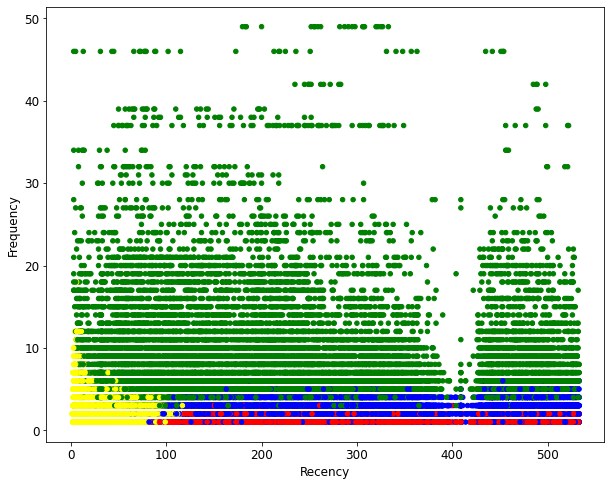

In [34]:
plt.figure(figsize=(7,7))

colors = ["red", "green", "blue", "yellow"]
df1['Color'] = df1['Cluster'].map(lambda p: colors[p])
ax = df1.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = df1['Color']
)

In [35]:
df1['RFM_Loyalty_Level'].value_counts()

Silver      34722
Platinum    32402
Gold        27784
Bronze      17416
Name: RFM_Loyalty_Level, dtype: int64

In [36]:
df1.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
0,944773,500,1,18,4,4,4,444,12,Bronze,0,red
1,1255828,465,3,120,4,2,3,423,9,Silver,2,blue
2,1246564,467,1,50,4,4,4,444,12,Bronze,0,red
3,1336015,448,1,15,3,4,4,344,11,Bronze,0,red
4,1424707,436,1,85,3,4,3,343,10,Silver,0,red


In [37]:
df1.to_excel("Enuygun_customer_segmentation.xlsx")